In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 决策边界 (Decision Boundary)

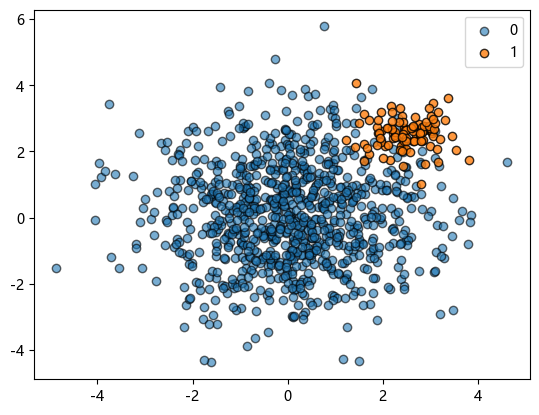

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=[900, 100],
                  centers=[[0.0, 0.0], [2.5, 2.5]],
                  cluster_std=[1.5, 0.5],
                  random_state=42)


plt.scatter(X[y==0, 0], X[y==0, 1], ec="k", alpha=0.6, label="0")
plt.scatter(X[y==1, 0], X[y==1, 1], ec="k", alpha=0.8, label="1")
plt.legend();

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

SVM作为分类器，使用分割超平面分割两类。SVC的decision_function方法用来返回每个样本离分割超平面的距离。一般来说，通关判断离分割超平面面是否大于$0$以判断是$1$还是$0$。

In [5]:
from sklearn.svm import SVC

model = SVC(kernel="rbf", C=1, gamma=0.05)
model.fit(X_train, y_train)

print(f"  The count of decision value <= 0:", (model.decision_function(X[y==1]) < 0).sum())
print(f"The minimum of decision value of 1:", model.decision_function(X[y==1]).min())

decision_boundary = model.decision_function(X[y==1]).min()

  The count of decision value <= 0: 10
The minimum of decision value of 1: -0.6492058604484552


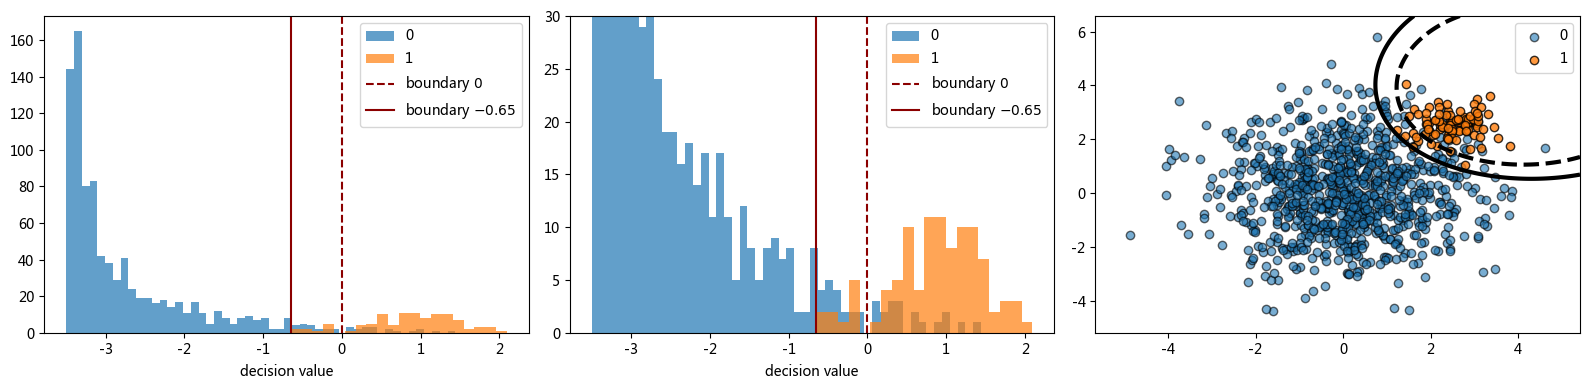

In [286]:
from plot_helper import plot_2d_separator
fig, axes  = plt.subplots(1,3, figsize=(16, 4), dpi=100)
for i in range(2):
    ax = axes[i]
    ax.hist(model.decision_function(X[y==0]), label="0", bins=50, alpha=0.7)
    ax.hist(model.decision_function(X[y==1]), label="1", bins=20, alpha=0.7)    
    ax.set_xlabel("decision value")
    ax.axvline(0, ls="--", c="darkred", label="boundary $0$")
    ax.axvline(decision_boundary, ls="-", c="darkred", label=f"boundary ${decision_boundary:0.2f}$")
    ax.legend()
    
axes[1].set_ylim(0, 30)

ax = axes[2]
ax.scatter(X[y==0, 0], X[y==0, 1], ec="k", alpha=0.6, label="0")
ax.scatter(X[y==1, 0], X[y==1, 1], ec="k", alpha=0.8, label="1")
plot_2d_separator(svc, X, linewidth=3, threshold=0, linestyle="--", ax=ax)
plot_2d_separator(svc, X, linewidth=3, threshold=decision_boundary, linestyle="-", ax=ax)
ax.legend()

plt.tight_layout()

In [8]:
from sklearn.metrics import classification_report

print("== Decision boundary is 0")
print(classification_report(y_test, model.predict(X_test)))

print("== Decision boundary is", decision_boundary)
print(classification_report(y_test, model.decision_function(X_test) >= decision_boundary))

== Decision boundary is 0
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       225
           1       0.81      0.84      0.82        25

    accuracy                           0.96       250
   macro avg       0.89      0.91      0.90       250
weighted avg       0.96      0.96      0.96       250

== Decision boundary is -0.6492058604484552
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       225
           1       0.74      1.00      0.85        25

    accuracy                           0.96       250
   macro avg       0.87      0.98      0.91       250
weighted avg       0.97      0.96      0.97       250



# Precision-Recall 曲线

在现实中，人们往往对查全率和查准率都有要求，但是会根据应用场景偏向某一边。比如做疾病检测，我们希望尽可能地把疾病检测出来，但同时也不想检测结果的准确率太低，因为这样会造成恐慌和不必要的医疗支出（偏向recall）。又比如对于垃圾邮件检测（Spam Detection），我们希望检测出的垃圾邮件肯定是垃圾邮件，而不希望把正常邮件邮件归为垃圾邮件，因为这样有可能会给客户造成很大的损失，但是相对地，如果我们经常把垃圾邮件归为正常邮件，虽然不会造成很大损失，但是会影响用户体验（偏向precision）。再比如如果是做搜索，搜出来的网页都和关键词相关才是好的搜索引擎，在这种情况下，我们希望precision高一些（偏向precision）。这时就要用到PR曲线。

 

PR曲线：x轴为查全率，y轴为查准率。


PR曲线的应用场景：需要根据需求找到对应的precision和recall值。如果偏向precison，那就是在保证recall的情况下提升precision；如果偏向recall，那就是在保证precision的情况下提升recall。比如对于欺诈检测（Fraud Detection），如果要求预测出的潜在欺诈人群尽可能准确，那么就要提高precision；而如果要尽可能多地预测出潜在的欺诈人群，那么就是要提高recall。一般来说，提高二分类模型的分类阈值就能提高precision，降低分类阈值就能提高 recall，这时便可观察PR 曲线，根据自己的需要，找到最优的分类阈值（threshold）。


In [18]:
def plot_precision_recall_curve(model, X, y):
    precision, recall, thresholds = precision_recall_curve(y, model.decision_function(X))

    close_zero = np.argmin(np.abs(thresholds)) # 最接近阈值为0的点

    fig, axes = plt.subplots(1,2, figsize=(16, 4), dpi=100)
    ax = axes[0]
    ax.plot(precision, recall, label="precision recall curve")
    ax.set_xlim(0,1.05)
    ax.set_ylim(0,1.05)
    ax.axvline(0.5, c="grey", lw=1, ls="--")
    ax.axhline(1, c="grey", lw=1)

    ax.scatter(precision[close_zero], recall[close_zero], marker='o',  s=80, label="threshold zero",  ec='k', c="none")
    ax.set_xlabel("Precision") 
    ax.set_ylabel("Recall")
    ax.legend(loc="best")

    ax = axes[1]
    ax.hist(model.decision_function(X[y==0]), label="0", bins=100)
    ax.hist(model.decision_function(X[y==1]), label="1", bins=20, alpha=0.6)    
    ax.set_xlabel("decision value")
    ax.axvline(thresholds[close_zero], ls="--", c="k", label="threshold $0$")
    ax.legend()
    plt.tight_layout()

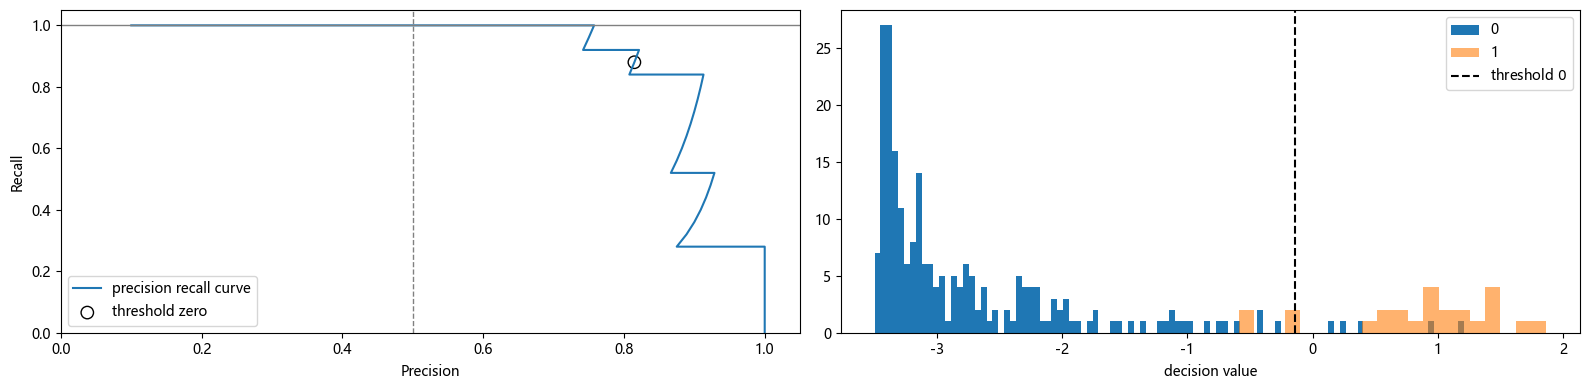

In [19]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, model.decision_function(X_test))

plot_precision_recall_curve(model, X_test, y_test)

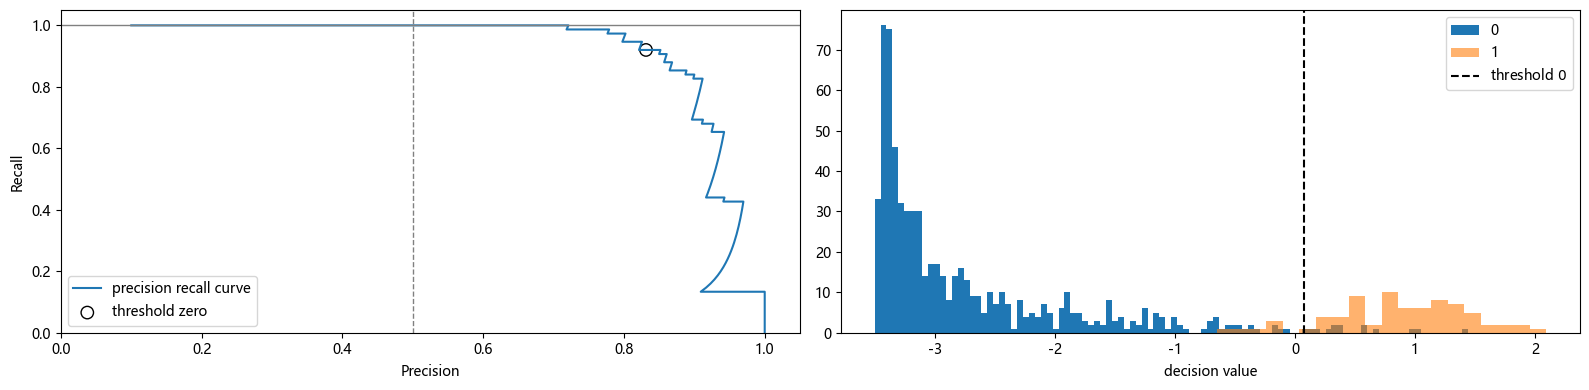

In [21]:
precision, recall, thresholds = precision_recall_curve(y_train, model.decision_function(X_train))
plot_precision_recall_curve(model, X_train, y_train)

# ROC曲线
ROC是英文Receiver Operating Characteristics（接收器工作特征）的简称。

ROC曲线反映在不同决策阈值情况下**真阳率**与**假阳率**关系，也即**灵敏度**与**误报率**之间关系。

> 最早，该图用来显示雷达的性能，从雷达信号中发现飞行物，识别飞行物的灵敏度和误报率。

In [25]:
from sklearn.metrics import roc_curve
def plot_roc(model, X, y):
    fpr, tpr, thresholds  = roc_curve(y, model.decision_function(X))

    close_zero = np.argmin(np.abs(thresholds)) # 最接近阈值为0的点

    fig, axes = plt.subplots(1,2, figsize=(16, 4), dpi=120)
    ax = axes[0]
    ax.plot(fpr, tpr, label="precision recall curve")
    ax.set_xlim(0,1.05)
    ax.set_ylim(0,1.05)

    ax.scatter(fpr[close_zero], tpr[close_zero], marker='o',  s=80, label="threshold zero",  ec='k', c="none")
    ax.set_xlabel("FPR") 
    ax.set_ylabel("TPR(Recall)")
    ax.legend(loc=4)

    ax = axes[1]
    ax.hist(model.decision_function(X[y==0]), label="0", bins=100)
    ax.hist(model.decision_function(X[y==1]), label="1", bins=20, alpha=0.6)    
    ax.set_xlabel("decision value")
    ax.axvline(thresholds[close_zero], ls="--", c="k", label="threshold $0$")
    ax.legend()
    plt.tight_layout()

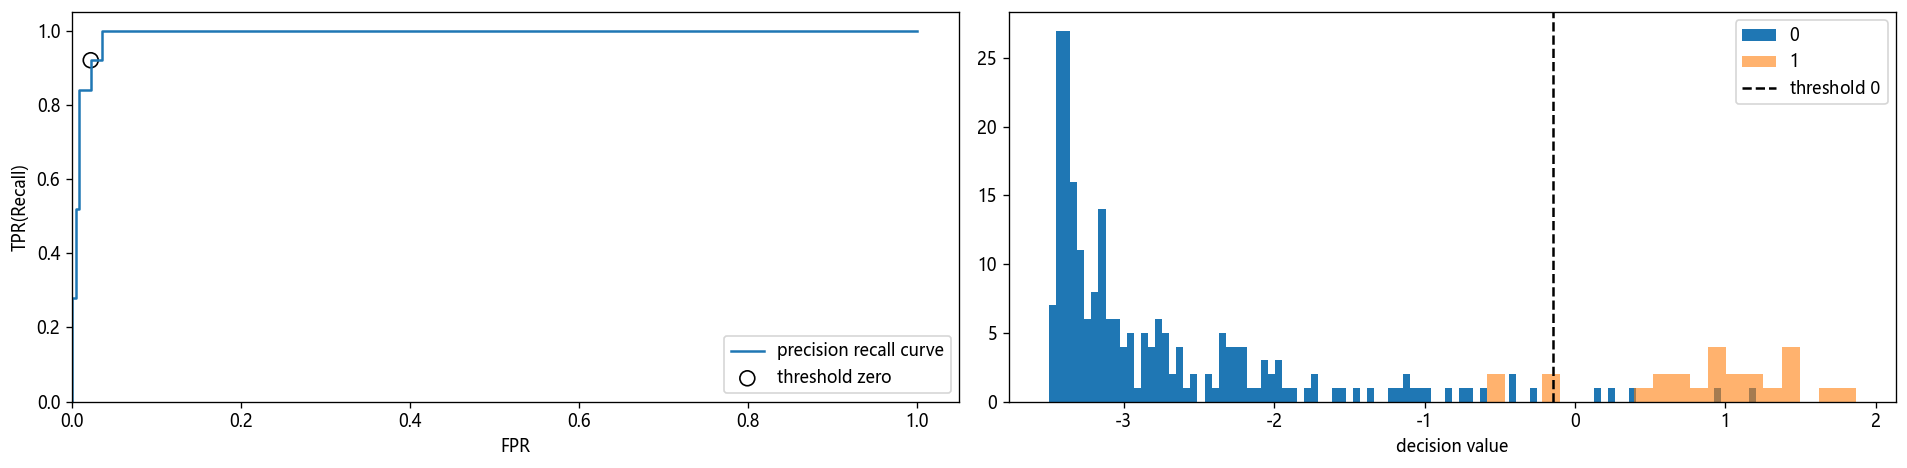

In [26]:
plot_roc(model, X_test, y_test)

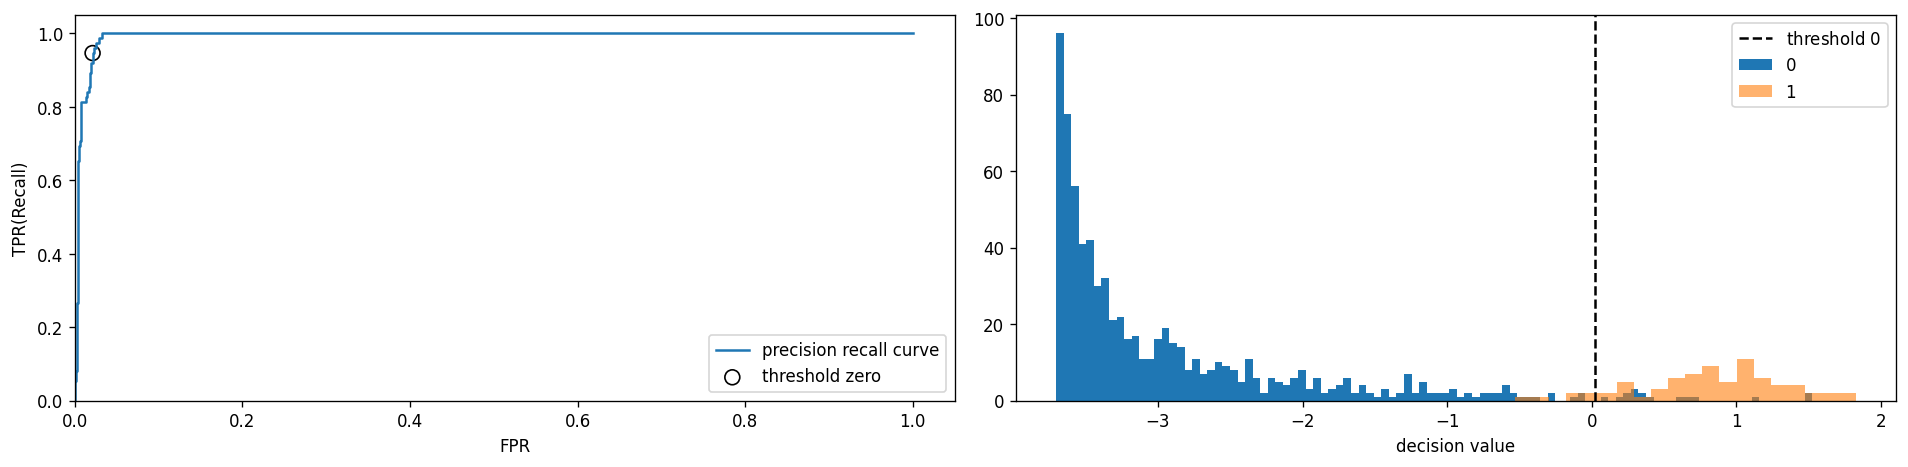

In [29]:
plot_roc(svc, X_train, y_train)

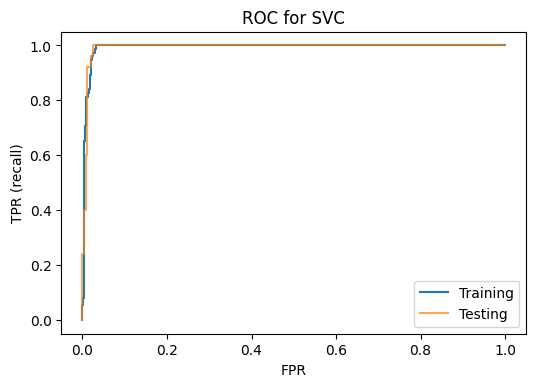

In [30]:
from sklearn.metrics import roc_curve

plt.figure(dpi=100)

fpr, tpr, thresholds = roc_curve(y_train, svc.decision_function(X_train))
plt.plot(fpr, tpr, label="Training")


fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))
plt.plot(fpr, tpr, label="Testing", alpha=0.7)


plt.xlabel("FPR"); plt.ylabel("TPR (recall)")
plt.title("ROC for SVC")
plt.legend(loc=4);

如何比较ROC的曲线，可以计算曲线下的面积（Area Under Curve）作为比较依据

In [28]:
from sklearn.metrics import roc_auc_score

train_auc = roc_auc_score(y_train, model.decision_function(X_train))
test_auc = roc_auc_score(y_test, model.decision_function(X_test))

print(f"AUC for training: { train_auc :.3f}")
print(f"AUC for testing: { test_auc :.3f}")

AUC for training: 0.993
AUC for testing: 0.991


如果预测结果完全是随机的，此时曲线在理论上呈现一条直线。

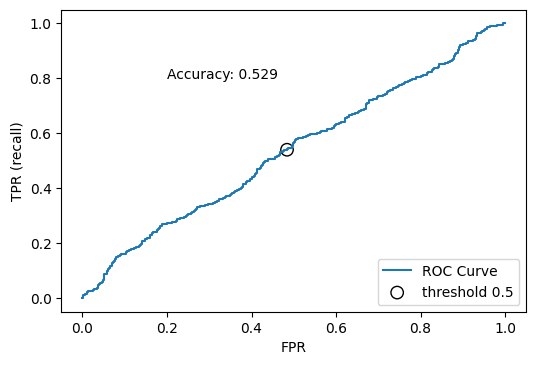

In [32]:
rnd = np.random.RandomState(42)

y_true = np.r_[np.zeros(500), np.ones(500)]
rnd.shuffle(y_true)

# 决策完全是随机猜测的，不妨认为每个决策值来源于0到1的均匀分布
decision_values = rnd.uniform(0,1,size=1000)

# 根据decision value判断是0还是1
y_pred = decision_values >=0.5


from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, decision_values)

fig, ax = plt.subplots(dpi=100)

ax.plot(fpr, tpr, label="ROC Curve")
close_zero = np.argmin(np.abs(thresholds -0.5))
ax.scatter(fpr[close_zero], tpr[close_zero], marker='o',  s=80, label="threshold 0.5", ec='k', c="none")


from sklearn.metrics import accuracy_score
score = accuracy_score(y_true, y_pred)
ax.text(0.2, 0.8, f"Accuracy:{score: .3f}")

ax.set_xlabel("FPR"); ax.set_ylabel("TPR (recall)")
ax.legend(loc=4);

下面，再来看一下，预测完全是随机猜测情况下,Precision-Recall曲线的形态。

1. 理论上，$\mathrm{Precision}$值应该是0.5，因为预测完全随机猜测0或1，也就是一半对一半。
2. 随着决策阈值越来越大，判定为$1$的比例从一开始的$100\%$到最后的$0\%$，$\mathrm{Recall}$值从最大值降到最小值$0$。
3. 当阈值接近最大值$1$是，呈阳性类的比例也越来越少，不确定性增大，此时$\mathrm{Precision}$值变换波动加大。

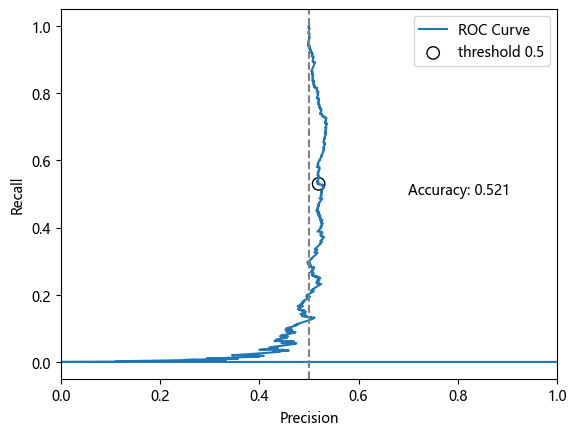

In [32]:
rnd = np.random.RandomState(1)

y_true = np.r_[np.zeros(500), np.ones(500)]
rnd.shuffle(y_true)

# 决策完全是随机猜测的，不妨认为每个决策值来源于0到1的均匀分布
decision_values = rnd.uniform(0,1,size=1000)

# 根据decision value判断是0还是1
y_pred = decision_values >=0.5


from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, decision_values)

fig, ax = plt.subplots(dpi=100)

ax.plot(precision, recall, label="ROC Curve")
close_zero = np.argmin(np.abs(thresholds-0.5))
ax.scatter(precision[close_zero], recall[close_zero], marker='o',  s=80, label="threshold 0.5", ec='k', c="none")


from sklearn.metrics import accuracy_score
score = accuracy_score(y_true, y_pred)
ax.text(0.7, 0.5, f"Accuracy:{score: .3f}")

ax.set_xlim(0,1)
ax.set_xlabel("Precision"); ax.set_ylabel("Recall")
ax.axvline(0.5, c="grey", ls="--")
ax.legend(loc=1);

### 小结：PR曲线和ROC曲线的区别

1. 在正负样本差距不大的情况下，ROC曲线和PR曲线的趋势是差不多的，但是当正负样本相差悬殊的时候（通常负样本比正样本多很多），两者就截然不同了，在ROC曲线上的效果依然看似很好，但是在PR曲线上就效果一般了。对于类别不平衡问题，ROC曲线的表现会比较稳定（不会受不均衡数据的影响），但如果我们希望看出模型在呈阳性分类上的表现效果，还是用PR曲线更好，因为此时ROC曲线通常会给出一个过于乐观的效果估计。

2. ROC曲线由于兼顾呈阳性分类与呈阴性分类，适用于评估分类器的整体性能（通常是计算AUC，表示模型的排序性能）；PR曲线则完全聚焦于呈阳性分类，因此如果我们主要关心的是呈阳性分类，那么用PR曲线比较好。

3. ROC曲线不会随着类别分布的改变而改变。然而，这一特性在一定程度上也是其缺点。因此需要根据不用的场景进行选择：比如对于欺诈检测，每个月呈阳性分类和呈阴性分类的比例可能都不相同，这时候如果只想看一下分类器的整体性能是否稳定，则用ROC曲线比较合适，因为类别分布的改变可能使得PR曲线发生变化，这种时候难以进行模型性能的比较；反之，如果想测试不同的类别分布对分类器性能的影响，则用PR曲线比较合适。

# 实验

In [33]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()

y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, stratify=y, random_state=0)

gamma = 0.01  accuracy = 0.90  AUC = 1.00
gamma = 0.05  accuracy = 0.90  AUC = 1.00
gamma = 1.00  accuracy = 0.90  AUC = 0.50


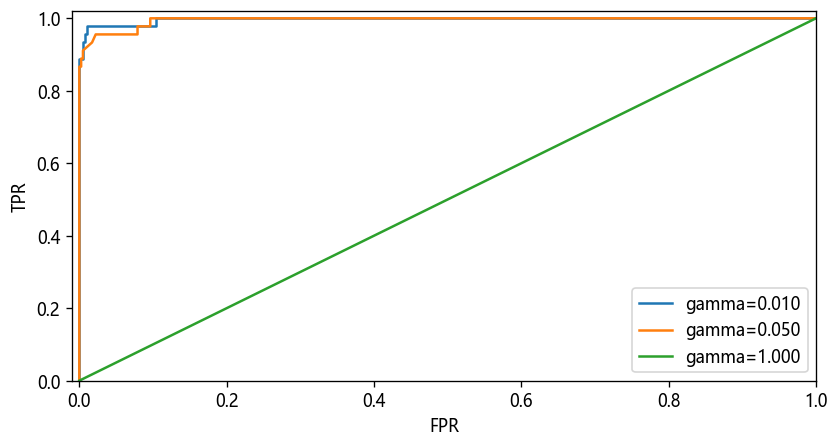

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8, 4), dpi=120)

for gamma in [0.01, 0.05, 1]:
    svc = SVC(gamma=gamma, C=1000).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
    
    print(f"gamma = {gamma :.2f}  accuracy = {accuracy :.2f}  AUC = {auc :.2f}")
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
    
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.xlim(-0.01, 1); plt.ylim(0, 1.02)
plt.legend(loc="best");

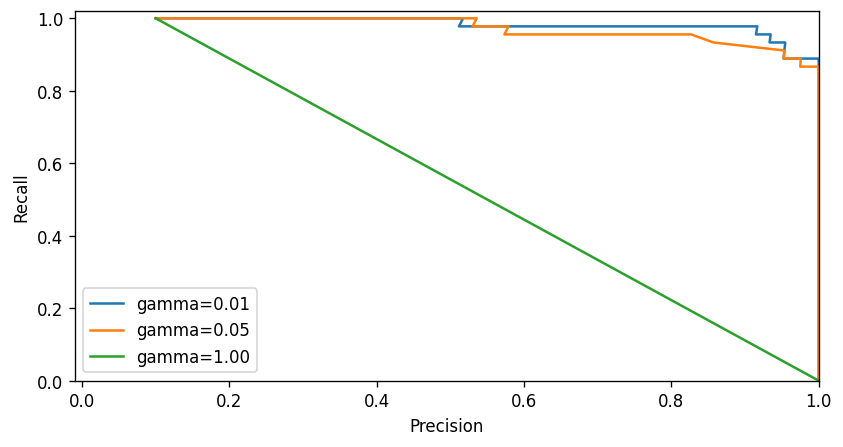

In [76]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 4), dpi=120)

for gamma in [0.01, 0.05, 1]:
    svc = SVC(gamma=gamma, C=1000).fit(X_train, y_train)
    precision, recall, _ = precision_recall_curve(y_test , svc.decision_function(X_test))
    plt.plot(precision, recall, label=f"gamma={ gamma :.2f}")
    
plt.xlabel("Precision"); plt.ylabel("Recall")
plt.xlim(-0.01, 1); plt.ylim(0, 1.02)
plt.legend(loc="best");

## 考虑模型不确定性的ROC曲线

In [36]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()

X, y = digits.data, (digits.target == 9).astype(int)

n_samples, n_features = X.shape

(6, 100)


D:\TGBAWork\.tgba_platform\venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
D:\TGBAWork\.tgba_platform\venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
D:\TGBAWork\.tgba_platform\venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
D:\TGBAWork\.tgba_platform\venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
D:\TGBAWork\.tgba_platform\venv\Lib\site

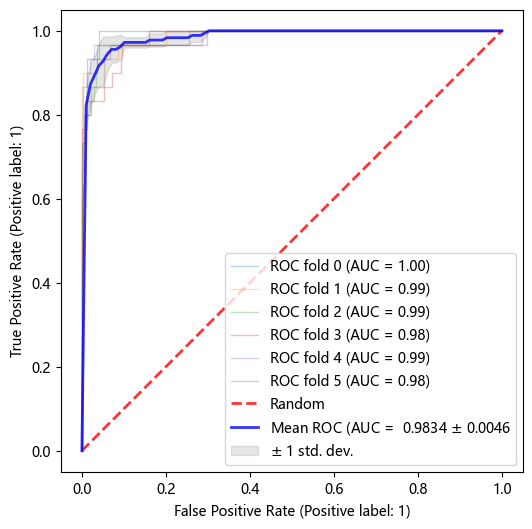

In [42]:
from sklearn.svm import SVC
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold


classifier = SVC(kernel="linear")

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,6), dpi=100)

cv = StratifiedKFold(n_splits=6)
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name=f"ROC fold {i}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )

   
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Random", alpha=0.8)

tprs = np.array(tprs)
print(tprs.shape)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=f"Mean ROC (AUC = {mean_auc: 0.4} $\pm$ {std_auc:0.4f}",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
)
ax.legend(loc="lower right")